In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.1
numpy 2.2.4
pandas 2.2.3
sklearn 1.6.1
torch 2.7.0+cpu
cpu


In [16]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

# 转化成张量并且进行归一化
transform = transforms.Compose([
    # ToTensor()
])

# train=true是加载训练集
train_ds = datasets.FashionMNIST(root='../chapter_2_torch/data', train=True, transform=transform, download=True)

#加载测试集
test_ds = datasets.FashionMNIST(root='../chapter_2_torch/data', train=False, transform=transform, download=True)



**训练集，验证集，测试集，之所以要分出来验证集是因为深度学习的能力很强，在调整参数的过程其实就是泄露了数据，所以测试集现在用来在上线时测试模型的表现，就是一锤子买卖，不能再进行调整参数了**

In [4]:
type(train_ds)

torchvision.datasets.mnist.FashionMNIST

In [5]:
len(train_ds)

60000

In [7]:
train_ds.data.shape

torch.Size([60000, 28, 28])

In [8]:
type(train_ds.data)

torch.Tensor

In [14]:
print(train_ds.train_labels.unique())

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [18]:
# 通过id取数据，取到的是一个元祖,是第一个样本,在训练时，把特征和标签分开
img, label = train_ds[0]
img.shape
# img.shape = (1, 28, 28)，这是因为通道数在最前面

AttributeError: 'Image' object has no attribute 'shape'

In [12]:
print(label)

9


In [19]:
type(img)

PIL.Image.Image

In [20]:
img

In [21]:
# 显示图片，这里需要把transforms.ToTensor(),进行归一化注释掉，否则是不行的
def show_img_content(img):
    from PIL import Image

    # 打开一个图像文件
    # img = Image.open(img)


    print("图像大小:", img.size)
    print("图像模式:", img.mode)


    # 如果图像是单通道的，比如灰度图，你可以这样获取像素值列表：
    if img.mode == 'L':
        pixel_values = list(img.getdata())
        print(pixel_values)
show_img_content(img) #这里必须把上面的 transforms.ToTensor(), # 转换为tensor，进行归一化注释掉，否则是不行的

图像大小: (28, 28)
图像模式: L
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 13, 73, 0, 0, 1, 4, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 36, 136, 127, 62, 54, 0, 0, 0, 1, 3, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 102, 204, 176, 134, 144, 123, 23, 0, 0, 0, 0, 12, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 236, 207, 178, 107, 156, 161, 109, 64, 23, 77, 130, 72, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 69, 207, 223, 218, 216, 216, 163, 127, 121, 122, 146, 141, 88, 172, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 200, 232, 232, 233, 229, 223, 223, 215, 213, 164, 127, 123, 196, 229, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 183, 225, 216, 223, 228, 235, 227, 224, 222, 224, 221, 223, 245, 173, 0, 0, 0, 

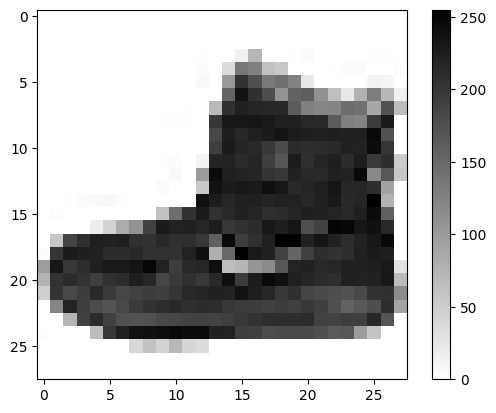

In [22]:
#这个代码必须是注释了上面的 transforms.ToTensor()才能够运行的
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap="binary") # 显示图片
    plt.colorbar() # 显示颜色条
    plt.show()


show_single_image(img)